In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, coherent_unitary_error

from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

# from qiskit.quantum_info import Kraus, SuperOp

# Import from Qiskit Aer noise module
# import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import GetGHZCircuitsForModel
from circuits.pqc_circuits import qiskit_PQC_RZRX_unique
from circuits.modify_circuits import append_pqc_to_quantum_circuit

from models.noise_models import BitPhaseFlipNoise
from models.qiskit_models import ScaledQiskitQuantumModel

from simulator.simulate import get_ideal_data, get_ideal_data_superpos

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 25

ideal_sim = AerSimulator(device=aer_device)

pqc_arch = qiskit_PQC_RZRX_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = ScaledQiskitQuantumModel(
    num_params=NUM_QUBITS*2, simulator=ideal_sim, num_shots=NUM_SHOTS, pqc_arch_func=pqc_arch
)

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
)



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(10000), device=aer_device)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:15<00:00, 656.61it/s]

32


In [9]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = [0]
    shuffle(ideal_data)
    data_iterator_tqdm = tqdm(ideal_data)
    for params, ideal in data_iterator_tqdm:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=ghz_circuit_gen.get_noisy_model_circuit_params(params))
        # print(ideal)
        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)
        
        loss = loss_fn(ideal, measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.raw_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        data_iterator_tqdm.set_postfix_str(f"Loss: {loss}")
        # print(param_list)


        # if (ctr) % (len(ideal_data) // 10) == 0:
            
    print(f'Loss: {np.mean(loss_list):.4f}, Params: {pqc_model.raw_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    param_arr = np.array(param_list).transpose()
    print(param_arr)    
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1


100%|██████████| 10000/10000 [01:41<00:00, 98.92it/s, Loss: 12398.8125]


Loss: 11670.4270, Params: Parameter containing:
tensor([-0.9465,  0.5016, -1.1693, -1.4331,  0.1434,  0.2606, -0.3996, -0.1396,
         0.5319, -1.0118], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.9465627  -0.94655323
  -0.94654375]
 [ 0.55446196  0.5544564   0.55445087 ...  0.50164366  0.50163865
   0.50163364]
 [-1.2924292  -1.2924162  -1.2924032  ... -1.1693224  -1.1693107
  -1.169299  ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.13961591 -0.13961451
  -0.1396131 ]
 [ 0.58794165  0.58793575  0.58792984 ...  0.53193307  0.53192776
   0.53192246]
 [-1.1183386  -1.1183274  -1.1183162  ... -1.0118093  -1.0117992
  -1.0117891 ]]
Starting Epoch 2


100%|██████████| 10000/10000 [01:51<00:00, 90.08it/s, Loss: 13546.4375]


Loss: 11405.5062, Params: Parameter containing:
tensor([-0.8564,  0.4538, -1.0579, -1.2965,  0.1298,  0.2357, -0.3615, -0.1263,
         0.4812, -0.9154], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.8563688  -0.8563602
  -0.8563516 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.4538445   0.45383996
   0.45383543]
 [-1.2924292  -1.2924162  -1.2924032  ... -1.057906   -1.0578954
  -1.0578848 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.12631284 -0.12631157
  -0.1263103 ]
 [ 0.58794165  0.58793575  0.58792984 ...  0.48125124  0.4812464
   0.48124158]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.915398   -0.9153888
  -0.91537964]]
Starting Epoch 3


100%|██████████| 10000/10000 [01:52<00:00, 88.81it/s, Loss: 8323.9375]


Loss: 11077.5772, Params: Parameter containing:
tensor([-0.7748,  0.4106, -0.9571, -1.1730,  0.1174,  0.2133, -0.3271, -0.1143,
         0.4354, -0.8282], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.77476937 -0.7747616
  -0.77475387]
 [ 0.55446196  0.5544564   0.55445087 ...  0.41060197  0.41059786
   0.41059375]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.9571043  -0.9570947
  -0.95708513]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.11427679 -0.11427564
  -0.11427449]
 [ 0.58794165  0.58793575  0.58792984 ...  0.43539494  0.4353906
   0.43538624]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.82817453 -0.82816625
  -0.82815796]]
Starting Epoch 4


100%|██████████| 10000/10000 [02:02<00:00, 81.42it/s, Loss: 4252.9375]


Loss: 10659.2237, Params: Parameter containing:
tensor([-0.7009,  0.3715, -0.8659, -1.0612,  0.1062,  0.1930, -0.2959, -0.1034,
         0.3939, -0.7492], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.70094454 -0.7009375
  -0.7009305 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.3714774   0.37147367
   0.37146994]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.86590236 -0.8658937
  -0.8658851 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.10338826 -0.10338723
  -0.10338619]
 [ 0.58794165  0.58793575  0.58792984 ...  0.3939077   0.39390376
   0.39389983]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.7492619  -0.7492544
  -0.7492469 ]]
Starting Epoch 5


100%|██████████| 10000/10000 [01:55<00:00, 86.30it/s, Loss: 5041.375] 


Loss: 10164.7157, Params: Parameter containing:
tensor([-0.6341,  0.3361, -0.7834, -0.9601,  0.0961,  0.1746, -0.2677, -0.0935,
         0.3564, -0.6779], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.6341507  -0.6341443
  -0.6341379 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.33608148  0.3360781
   0.33607474]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.7833954  -0.78338754
  -0.7833797 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.09353668 -0.09353574
  -0.0935348 ]
 [ 0.58794165  0.58793575  0.58792984 ...  0.35637465  0.35637107
   0.3563675 ]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.6778685  -0.6778617
  -0.6778549 ]]
Starting Epoch 6


100%|██████████| 10000/10000 [01:54<00:00, 87.61it/s, Loss: 6492.0]   


Loss: 9584.7248, Params: Parameter containing:
tensor([-0.5737,  0.3041, -0.7087, -0.8686,  0.0869,  0.1579, -0.2422, -0.0846,
         0.3224, -0.6133], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.57372683 -0.5737211
  -0.5737154 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.30405778  0.30405474
   0.3040517 ]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.7087526  -0.7087455
  -0.7087384 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.08462404 -0.08462319
  -0.08462234]
 [ 0.58794165  0.58793575  0.58792984 ...  0.32241684  0.32241362
   0.3224104 ]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.6132784  -0.61327225
  -0.6132661 ]]
Starting Epoch 7


100%|██████████| 10000/10000 [02:03<00:00, 80.72it/s, Loss: 4728.9375]


Loss: 8945.6517, Params: Parameter containing:
tensor([-0.5191,  0.2751, -0.6412, -0.7858,  0.0786,  0.1429, -0.2191, -0.0766,
         0.2917, -0.5548], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.5190626  -0.5190574
  -0.5190522 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.27508324  0.2750805
   0.27507776]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.64121735 -0.6412109
  -0.6412045 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.07656085 -0.07656008
  -0.07655931]
 [ 0.58794165  0.58793575  0.58792984 ...  0.2916969   0.291694
   0.29169106]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.55484116 -0.5548356
  -0.5548301 ]]
Starting Epoch 8


100%|██████████| 10000/10000 [01:55<00:00, 86.32it/s, Loss: 16079.9375]


Loss: 8274.7619, Params: Parameter containing:
tensor([-0.4696,  0.2489, -0.5801, -0.7110,  0.0712,  0.1293, -0.1982, -0.0693,
         0.2639, -0.5020], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.46960464 -0.46959993
  -0.46959522]
 [ 0.55446196  0.5544564   0.55445087 ...  0.24887456  0.24887207
   0.24886958]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.5801147  -0.58010894
  -0.58010316]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.06926581 -0.06926511
  -0.06926442]
 [ 0.58794165  0.58793575  0.58792984 ...  0.263901    0.26389834
   0.2638957 ]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.5019711  -0.5019661
  -0.5019611 ]]
Starting Epoch 9


100%|██████████| 10000/10000 [01:54<00:00, 87.08it/s, Loss: 2795.0]   


Loss: 7554.2284, Params: Parameter containing:
tensor([-0.4248,  0.2252, -0.5248, -0.6432,  0.0644,  0.1170, -0.1794, -0.0627,
         0.2388, -0.4541], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.42485797 -0.4248537
  -0.42484945]
 [ 0.55446196  0.5544564   0.55445087 ...  0.22516023  0.22515798
   0.22515573]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.5248438  -0.52483857
  -0.5248333 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.06266569 -0.06266507
  -0.06266444]
 [ 0.58794165  0.58793575  0.58792984 ...  0.23875605  0.23875366
   0.23875128]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.45414254 -0.45413798
  -0.45413342]]
Starting Epoch 10


100%|██████████| 10000/10000 [02:02<00:00, 81.36it/s, Loss: 7990.125] 


Loss: 6864.6480, Params: Parameter containing:
tensor([-0.3844,  0.2037, -0.4748, -0.5819,  0.0582,  0.1058, -0.1623, -0.0567,
         0.2160, -0.4109], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.38437557 -0.38437173
  -0.38436788]
 [ 0.55446196  0.5544564   0.55445087 ...  0.20370615  0.2037041
   0.20370206]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.47483325 -0.47482848
  -0.4748237 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.05669458 -0.05669402
  -0.05669345]
 [ 0.58794165  0.58793575  0.58792984 ...  0.21600679  0.21600462
   0.21600246]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.4108709  -0.4108668
  -0.41086268]]
Starting Epoch 11


100%|██████████| 10000/10000 [01:54<00:00, 87.19it/s, Loss: 8846.6875]


Loss: 6187.9812, Params: Parameter containing:
tensor([-0.3477,  0.1843, -0.4296, -0.5265,  0.0527,  0.0957, -0.1468, -0.0513,
         0.1954, -0.3717], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.3477503  -0.34774682
  -0.34774333]
 [ 0.55446196  0.5544564   0.55445087 ...  0.18429594  0.18429409
   0.18429224]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.42958918 -0.4295849
  -0.4295806 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.05129257 -0.05129206
  -0.05129154]
 [ 0.58794165  0.58793575  0.58792984 ...  0.19542406  0.19542211
   0.19542016]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.37172097 -0.37171724
  -0.37171352]]
Starting Epoch 12


100%|██████████| 10000/10000 [01:53<00:00, 88.08it/s, Loss: 3815.25]  


Loss: 5569.2015, Params: Parameter containing:
tensor([-0.3146,  0.1667, -0.3886, -0.4763,  0.0477,  0.0866, -0.1328, -0.0464,
         0.1768, -0.3363], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.31461415 -0.314611
  -0.31460783]
 [ 0.55446196  0.5544564   0.55445087 ...  0.16673544  0.16673377
   0.1667321 ]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.38865486 -0.38865095
  -0.38864705]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.04640507 -0.04640461
  -0.04640414]
 [ 0.58794165  0.58793575  0.58792984 ...  0.1768034   0.17680162
   0.17679985]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.33630174 -0.33629838
  -0.336295  ]]
Starting Epoch 13


100%|██████████| 10000/10000 [02:01<00:00, 82.22it/s, Loss: 3398.6875]


Loss: 5009.7944, Params: Parameter containing:
tensor([-0.2846,  0.1508, -0.3516, -0.4309,  0.0431,  0.0784, -0.1202, -0.0420,
         0.1600, -0.3043], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.2846353  -0.28463244
  -0.28462958]
 [ 0.55446196  0.5544564   0.55445087 ...  0.15084715  0.15084565
   0.15084414]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.35162342 -0.3516199
  -0.35161638]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.04198343 -0.04198301
  -0.04198259]
 [ 0.58794165  0.58793575  0.58792984 ...  0.1599553   0.1599537
   0.1599521 ]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.30425662 -0.30425358
  -0.30425054]]
Starting Epoch 14


100%|██████████| 10000/10000 [01:54<00:00, 87.44it/s, Loss: 2838.3125]


Loss: 4511.8542, Params: Parameter containing:
tensor([-0.2575,  0.1365, -0.3181, -0.3899,  0.0390,  0.0709, -0.1087, -0.0380,
         0.1447, -0.2753], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.2575121  -0.2575095
  -0.2575069 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.13647401  0.13647264
   0.13647127]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.31811914 -0.31811595
  -0.31811276]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.03798307 -0.03798269
  -0.03798231]
 [ 0.58794165  0.58793575  0.58792984 ...  0.14471507  0.14471363
   0.14471218]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.27526256 -0.27525982
  -0.27525708]]
Starting Epoch 15


100%|██████████| 10000/10000 [01:54<00:00, 87.58it/s, Loss: 3770.0]   


Loss: 4079.1448, Params: Parameter containing:
tensor([-0.2330,  0.1235, -0.2878, -0.3527,  0.0353,  0.0641, -0.0984, -0.0344,
         0.1309, -0.2490], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.2329777  -0.23297536
  -0.23297302]
 [ 0.55446196  0.5544564   0.55445087 ...  0.12347082  0.12346958
   0.12346835]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.2878061  -0.2878032
  -0.2878003 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.03436362 -0.03436328
  -0.03436294]
 [ 0.58794165  0.58793575  0.58792984 ...  0.13092645  0.13092513
   0.13092382]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.24903737 -0.24903488
  -0.2490324 ]]
Starting Epoch 16


100%|██████████| 10000/10000 [02:01<00:00, 82.05it/s, Loss: 647.9375] 


Loss: 3720.4375, Params: Parameter containing:
tensor([-0.2108,  0.1117, -0.2604, -0.3191,  0.0319,  0.0580, -0.0890, -0.0311,
         0.1184, -0.2253], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.21077855 -0.21077643
  -0.21077432]
 [ 0.55446196  0.5544564   0.55445087 ...  0.11170582  0.11170471
   0.11170359]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.26037994 -0.26037735
  -0.26037475]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.03108956 -0.03108925
  -0.03108894]
 [ 0.58794165  0.58793575  0.58792984 ...  0.11845107  0.11844989
   0.1184487 ]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.22530745 -0.2253052
  -0.22530295]]
Starting Epoch 17


100%|██████████| 10000/10000 [01:55<00:00, 86.25it/s, Loss: 3682.75]  


Loss: 3414.7011, Params: Parameter containing:
tensor([-0.1907,  0.1011, -0.2356, -0.2887,  0.0289,  0.0525, -0.0805, -0.0281,
         0.1072, -0.2038], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.19069499 -0.19069308
  -0.19069117]
 [ 0.55446196  0.5544564   0.55445087 ...  0.10106187  0.10106086
   0.10105985]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.23557295 -0.2355706
  -0.23556824]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.02812716 -0.02812688
  -0.0281266 ]
 [ 0.58794165  0.58793575  0.58792984 ...  0.10716452  0.10716344
   0.10716237]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.20383972 -0.20383768
  -0.20383564]]
Starting Epoch 18


100%|██████████| 10000/10000 [01:50<00:00, 90.49it/s, Loss: 7507.25]   


Loss: 3156.8166, Params: Parameter containing:
tensor([-0.1725,  0.0914, -0.2131, -0.2612,  0.0261,  0.0475, -0.0728, -0.0254,
         0.0970, -0.1844], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.17252475 -0.17252302
  -0.1725213 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.09143222  0.0914313
   0.09143039]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.2131265  -0.21312436
  -0.21312223]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.02544706 -0.0254468
  -0.02544655]
 [ 0.58794165  0.58793575  0.58792984 ...  0.09695306  0.0969521
   0.09695113]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.1844168  -0.18441495
  -0.1844131 ]]
Starting Epoch 19


100%|██████████| 10000/10000 [01:49<00:00, 91.39it/s, Loss: 3365.9375] 


Loss: 2943.5255, Params: Parameter containing:
tensor([-0.1561,  0.0827, -0.1928, -0.2363,  0.0236,  0.0430, -0.0659, -0.0230,
         0.0877, -0.1668], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.1560857  -0.15608414
  -0.15608257]
 [ 0.55446196  0.5544564   0.55445087 ...  0.08272006  0.08271923
   0.0827184 ]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.1928179  -0.19281596
  -0.19281402]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.02302232 -0.02302209
  -0.02302186]
 [ 0.58794165  0.58793575  0.58792984 ...  0.08771511  0.08771423
   0.08771335]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.16684462 -0.16684295
  -0.16684128]]
Starting Epoch 20


100%|██████████| 10000/10000 [01:56<00:00, 85.84it/s, Loss: 1756.25]   


Loss: 2763.5530, Params: Parameter containing:
tensor([-0.1412,  0.0748, -0.1744, -0.2138,  0.0214,  0.0389, -0.0596, -0.0208,
         0.0794, -0.1509], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.14121315 -0.14121173
  -0.14121032]
 [ 0.55446196  0.5544564   0.55445087 ...  0.07483756  0.07483681
   0.07483605]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.17444588 -0.17444414
  -0.1744424 ]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.02082868 -0.02082847
  -0.02082826]
 [ 0.58794165  0.58793575  0.58792984 ...  0.07935682  0.07935602
   0.07935522]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.15094557 -0.15094407
  -0.15094256]]
Starting Epoch 21


100%|██████████| 10000/10000 [01:55<00:00, 86.73it/s, Loss: 3287.4375] 


Loss: 2615.8121, Params: Parameter containing:
tensor([-0.1278,  0.0677, -0.1578, -0.1934,  0.0194,  0.0352, -0.0539, -0.0188,
         0.0718, -0.1366], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.12775767 -0.12775639
  -0.1277551 ]
 [ 0.55446196  0.5544564   0.55445087 ...  0.0677073   0.06770662
   0.06770594]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.15782411 -0.15782253
  -0.15782095]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.01884394 -0.01884375
  -0.01884356]
 [ 0.58794165  0.58793575  0.58792984 ...  0.07179479  0.07179407
   0.07179336]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.13656366 -0.13656229
  -0.13656092]]
Starting Epoch 22


100%|██████████| 10000/10000 [01:50<00:00, 90.90it/s, Loss: 1848.8125] 


Loss: 2499.2404, Params: Parameter containing:
tensor([-0.1156,  0.0613, -0.1428, -0.1750,  0.0175,  0.0318, -0.0488, -0.0170,
         0.0650, -0.1235], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.11558417 -0.11558302
  -0.11558186]
 [ 0.55446196  0.5544564   0.55445087 ...  0.06125573  0.06125512
   0.06125451]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.14278594 -0.1427845
  -0.14278308]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.01704836 -0.01704819
  -0.01704802]
 [ 0.58794165  0.58793575  0.58792984 ...  0.06495436  0.06495371
   0.06495306]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.12355171 -0.12355047
  -0.12354924]]
Starting Epoch 23


100%|██████████| 10000/10000 [01:51<00:00, 90.07it/s, Loss: 1102.9375] 


Loss: 2395.8754, Params: Parameter containing:
tensor([-0.1046,  0.0554, -0.1292, -0.1583,  0.0158,  0.0288, -0.0441, -0.0154,
         0.0588, -0.1118], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.10457042 -0.10456937
  -0.10456832]
 [ 0.55446196  0.5544564   0.55445087 ...  0.05541908  0.05541853
   0.05541797]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.1291804  -0.1291791
  -0.12917781]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.01542403 -0.01542388
  -0.01542372]
 [ 0.58794165  0.58793575  0.58792984 ...  0.05876554  0.05876495
   0.05876436]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.11177893 -0.11177781
  -0.11177669]]
Starting Epoch 24


100%|██████████| 10000/10000 [01:52<00:00, 89.22it/s, Loss: 3955.75]   


Loss: 2322.3387, Params: Parameter containing:
tensor([-0.0946,  0.0501, -0.1169, -0.1432,  0.0143,  0.0260, -0.0399, -0.0140,
         0.0532, -0.1011], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.09460686 -0.09460592
  -0.09460497]
 [ 0.55446196  0.5544564   0.55445087 ...  0.0501384   0.0501379
   0.05013739]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.11687173 -0.11687056
  -0.11686939]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.01395436 -0.01395422
  -0.01395408]
 [ 0.58794165  0.58793575  0.58792984 ...  0.05316605  0.05316552
   0.05316499]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.10112816 -0.10112715
  -0.10112613]]
Starting Epoch 25


100%|██████████| 10000/10000 [01:53<00:00, 87.79it/s, Loss: 646.625]   


Loss: 2252.2110, Params: Parameter containing:
tensor([-0.0856,  0.0454, -0.1057, -0.1296,  0.0130,  0.0236, -0.0361, -0.0126,
         0.0481, -0.0915], requires_grad=True)
[[-1.0462224  -1.046212   -1.0462015  ... -0.08559231 -0.08559145
  -0.08559059]
 [ 0.55446196  0.5544564   0.55445087 ...  0.04536102  0.04536057
   0.04536011]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.10573556 -0.1057345
  -0.10573344]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.01262469 -0.01262456
  -0.01262444]
 [ 0.58794165  0.58793575  0.58792984 ...  0.04810001  0.04809953
   0.04809904]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.09149218 -0.09149126
  -0.09149034]]


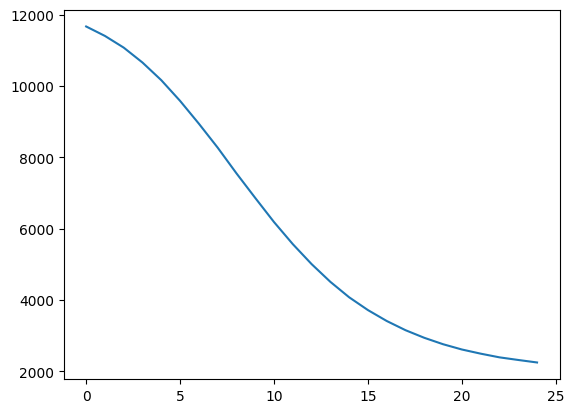

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[-1.0462224  -1.046212   -1.0462015  ... -0.08559231 -0.08559145
  -0.08559059]
 [ 0.55446196  0.5544564   0.55445087 ...  0.04536102  0.04536057
   0.04536011]
 [-1.2924292  -1.2924162  -1.2924032  ... -0.10573556 -0.1057345
  -0.10573344]
 ...
 [-0.1543152  -0.15431365 -0.1543121  ... -0.01262469 -0.01262456
  -0.01262444]
 [ 0.58794165  0.58793575  0.58792984 ...  0.04810001  0.04809953
   0.04809904]
 [-1.1183386  -1.1183274  -1.1183162  ... -0.09149218 -0.09149126
  -0.09149034]]


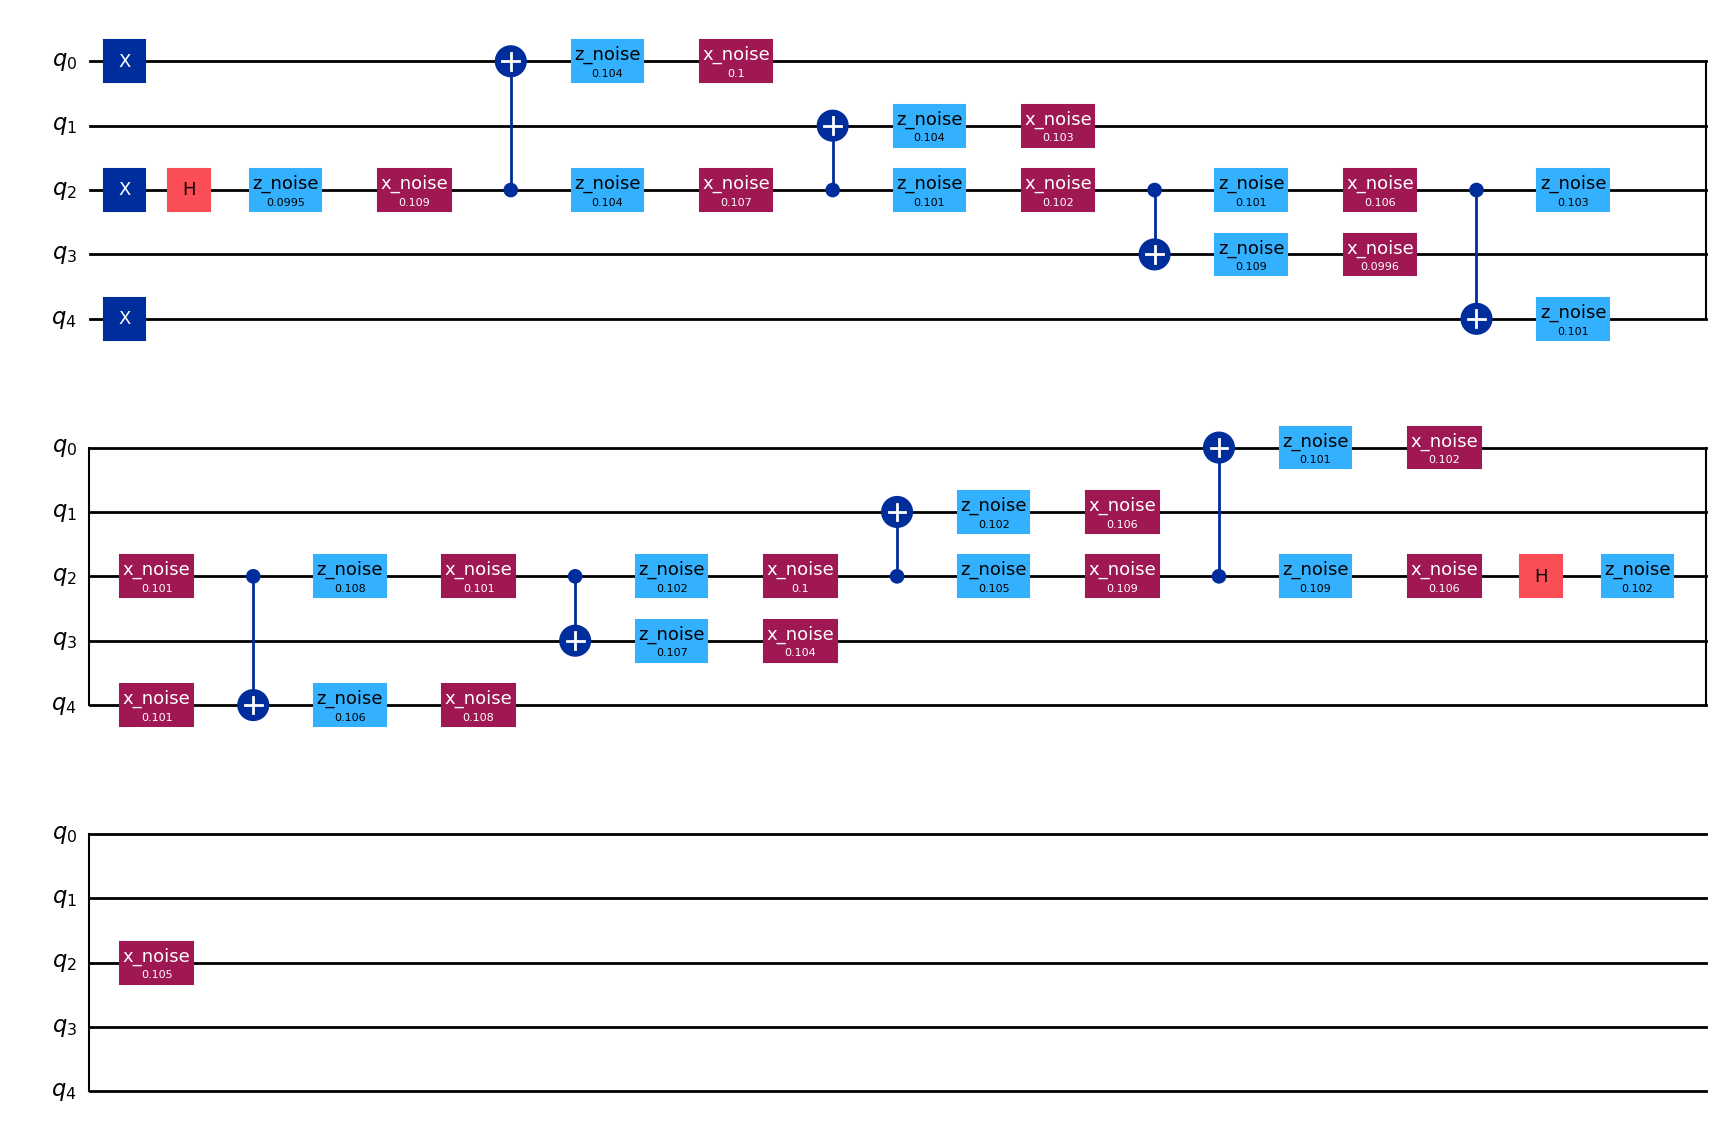

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

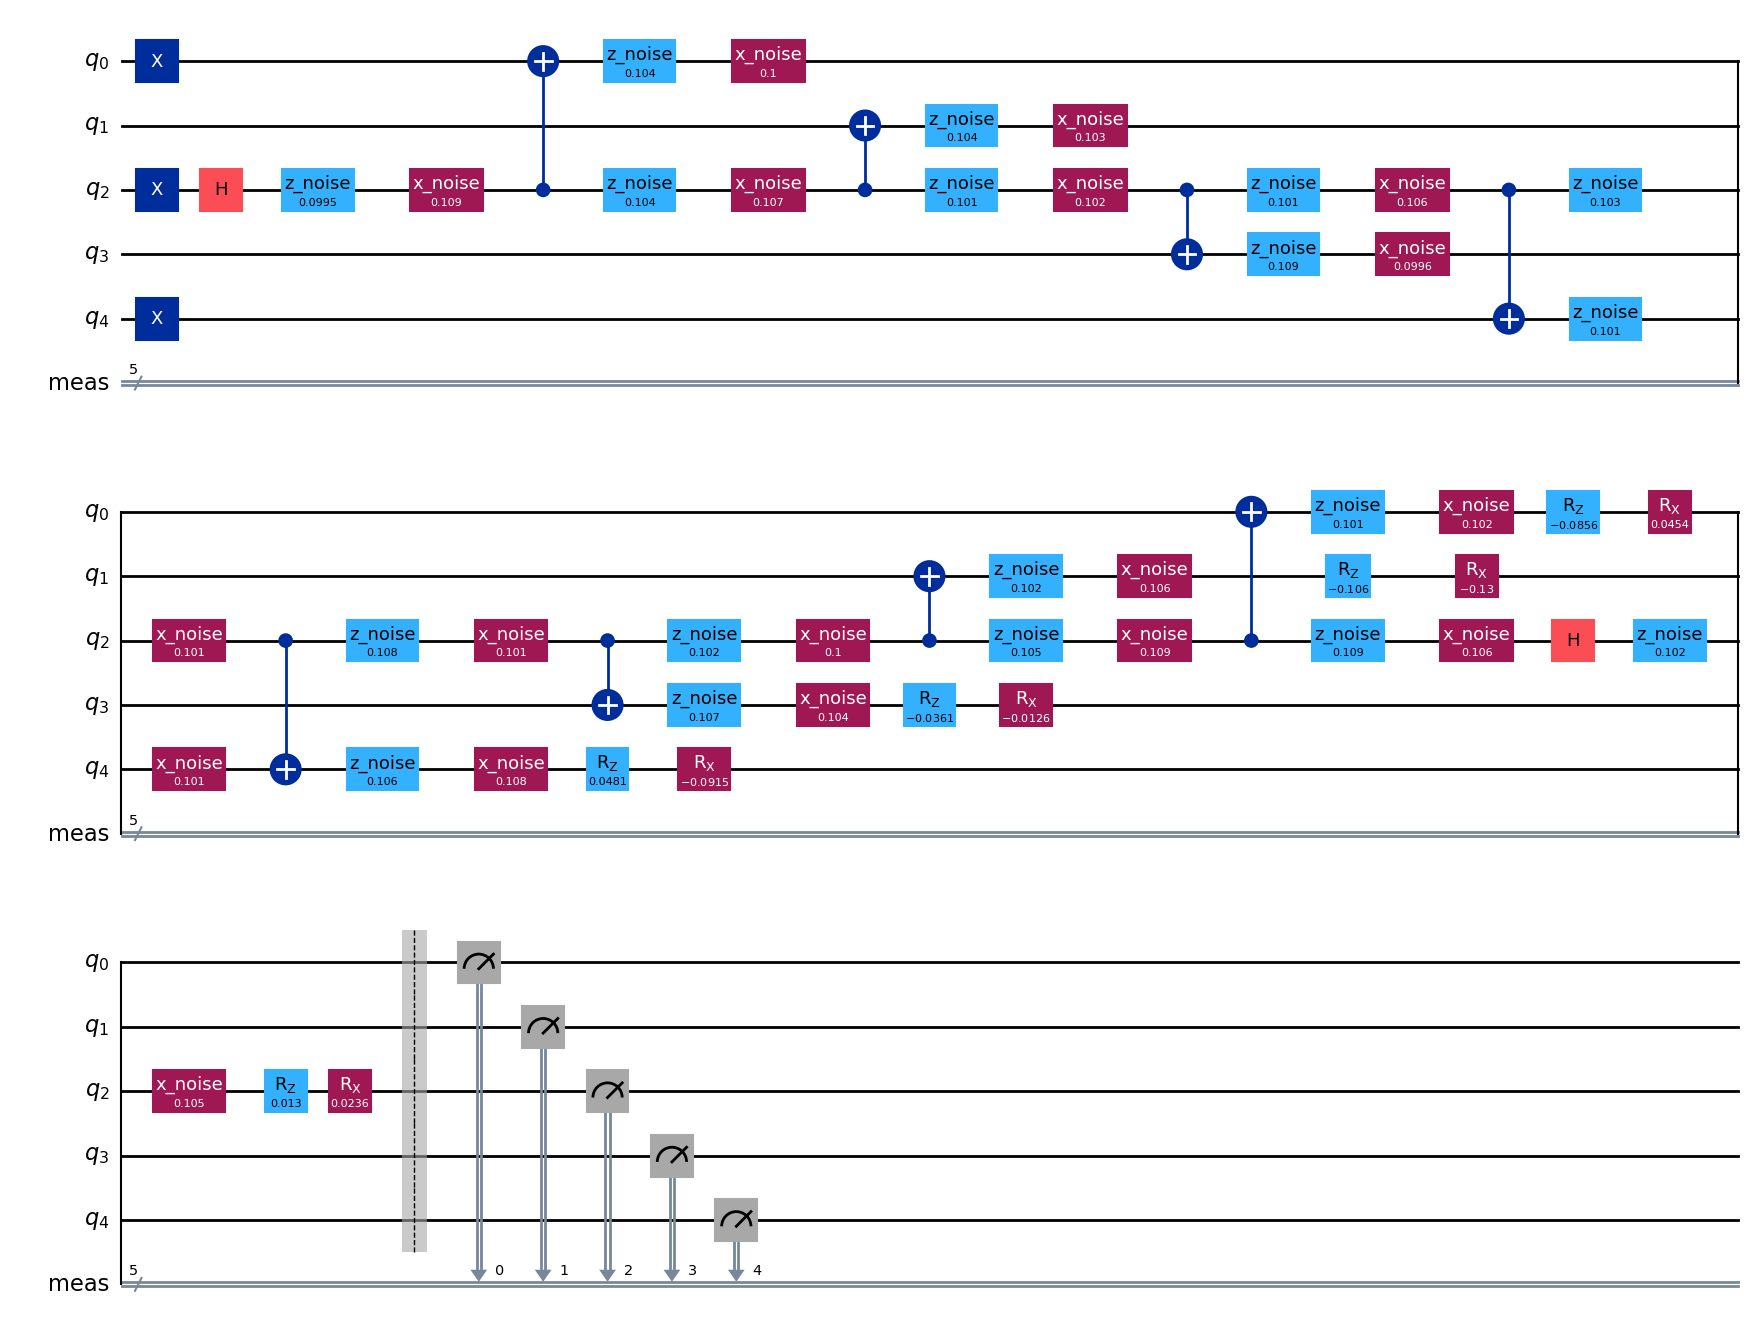

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, pqc_arch)
noisy_model_circ_pqc.draw('mpl')

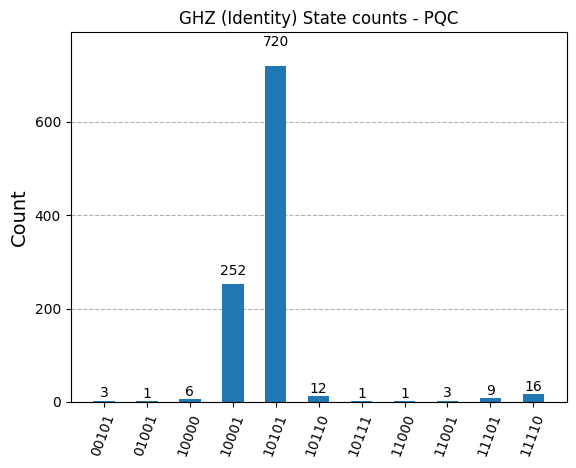

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

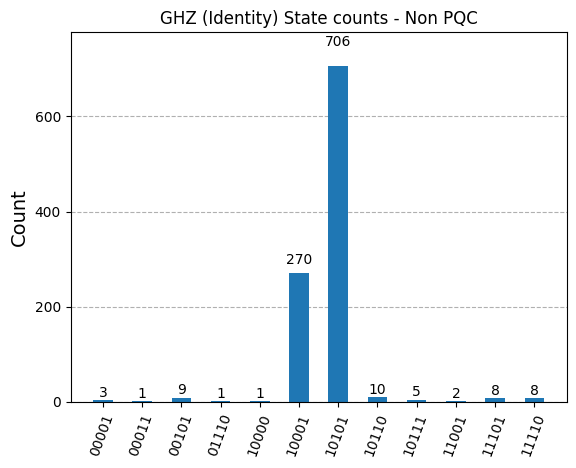

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')